# Modelado - Spotify Processed Dataset
Este notebook entrena y evalúa modelos de regresión para predecir `popularity` usando las versiones Z-score de las features.
Se comparan Random Forest y XGBoost.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
# Cargar dataset procesado
df = pd.read_csv('../data/processed/spotify_processed.csv')
df.head()

,danceability,energy,valence,tempo,liveness,speechiness,acousticness,instrumentalness,popularity,danceability_minmax,...,liveness_minmax,liveness_std,speechiness_minmax,speechiness_std,acousticness_minmax,acousticness_std,instrumentalness_minmax,instrumentalness_std,popularity_minmax,popularity_std
0,71.0,83.0,87.0,105.0,16.0,4.0,11.0,0.0,40.0,0.706667,...,0.146341,-0.225023,0.020408,-0.645270,0.112245,-0.502676,0.000000,-0.348010,0.5000,0.434210
1,70.0,85.0,87.0,117.0,32.0,4.0,0.0,0.0,42.0,0.693333,...,0.341463,0.777296,0.020408,-0.645270,0.000000,-0.877792,0.000000,-0.348010,0.5250,0.545808
2,71.0,89.0,63.0,121.0,64.0,8.0,0.0,20.0,29.0,0.706667,...,0.731707,2.781935,0.102041,-0.301955,0.000000,-0.877792,0.217391,0.628897,0.3625,-0.179581
3,78.0,84.0,97.0,122.0,12.0,4.0,12.0,0.0,24.0,0.800000,...,0.097561,-0.475603,0.020408,-0.645270,0.122449,-0.468575,0.000000,-0.348010,0.3000,-0.458576
4,77.0,71.0,70.0,123.0,10.0,7.0,4.0,1.0,30.0,0.786667,...,0.073171,-0.600892,0.081633,-0.387784,0.040816,-0.741386,0.010870,-0.299164,0.3750,-0.123781


In [3]:
# Definir variables predictoras (Z-score) y target
std_cols = [c for c in df.columns 
            if c.endswith('_std') and c != 'popularity_std']
X = df[std_cols]
y = df['popularity']
print('Número de muestras:', X.shape[0])
print('Número de features:', X.shape[1])

Número de muestras: 551443
Número de features: 8


In [4]:
# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Definir modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# --- Validación cruzada ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')
print("R² CV por pliegue:", np.round(cv_scores, 3))
print("R² CV promedio:  ", np.round(cv_scores.mean(), 3))
print("R² CV std:       ", np.round(cv_scores.std(), 3))

# --- Entrenamiento final y evaluación en Test ---
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf  = r2_score(y_test, y_pred_rf)
print(f"\nRandom Forest (Test) -> MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

R² CV por pliegue: [0.495 0.488 0.494 0.488 0.492]
R² CV promedio:   0.491
R² CV std:        0.003

Random Forest (Test) -> MSE: 165.16, R²: 0.49


In [6]:
# Entrenar y evaluar XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost -> MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f}")

XGBoost -> MSE: 271.98, R2: 0.17


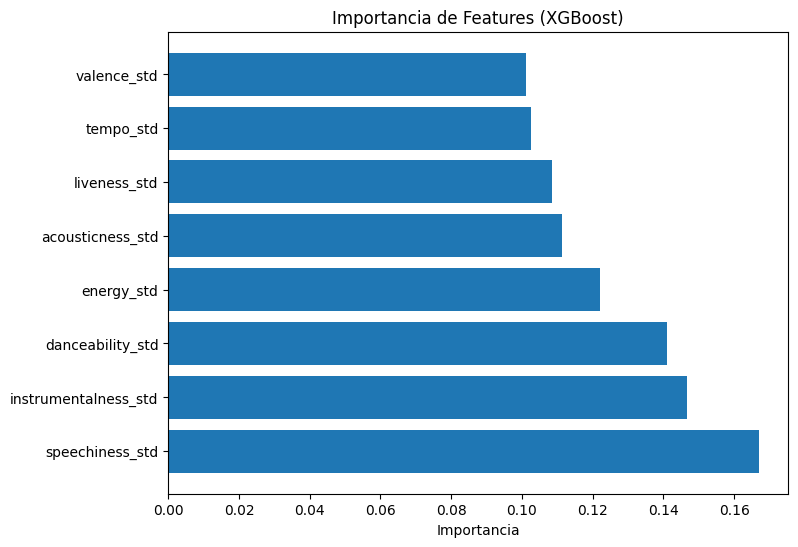

In [7]:
# Importancia de features del modelo XGBoost
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,6))
plt.barh([std_cols[i] for i in indices], importances[indices])
plt.title('Importancia de Features (XGBoost)')
plt.xlabel('Importancia')
plt.show()